In [18]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

### GPU 설정

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0' :
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4589645293125753446
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2255906407
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14300509459699643347
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


### SGD를 사용한 MF 기본 알고리즘

In [4]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./data/u.data', names=r_cols, sep='\t', encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)

In [5]:
# MF class
class MF() : 
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True) : 
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        # 아래는 파라미터로 받아본 변수를 클래스에 저장하는 부분
        self.K = K
        self.alpha = alpha
        self.beta = beta 
        self.iterations = iterations
        self.verbose = verbose
    
    # RMSE 계산
    def rmse(self) : 
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys) : 
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
     
    def train(self) :
        # 사용자-특징, 영화-특징 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) 
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K)) 

        # bias term 초기화
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # training samples의 리스트
        rows, columns = self.R.nonzero()
        # SGD를 적용할 대상(평점이 있는 요소의 인덱스와 평점)을 인덱스로 만들어 sample에 저장하기
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # SGD
        training_process = []
        for i in range(self.iterations) : 
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose : 
                if (i+1) % 10 == 0 : 
                    print('Iteration: %d ; Train RMSE = %.4f' % (i+1, rmse))
        return training_process
    
    # 사용자 i와 아이템 j에 대한 평점 예측
    def get_prediction(self, i, j) : 
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    # 최적화된 P와 Q 행렬을 얻기위한 SGD
    def sgd(self) : 
        for i, j, r in self.samples : 
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i,:] += self.alpha * (e * self.Q[j,:] - self.beta * self.P[i,:])
            self.Q[j,:] += self.alpha * (e * self.P[i,:] - self.beta * self.Q[j,:])

# 전체 데이터 사용 MF
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True) 
train_process = mf.train()   




Iteration: 10 ; Train RMSE = 0.9585
Iteration: 20 ; Train RMSE = 0.9373
Iteration: 30 ; Train RMSE = 0.9280
Iteration: 40 ; Train RMSE = 0.9225
Iteration: 50 ; Train RMSE = 0.9183
Iteration: 60 ; Train RMSE = 0.9145
Iteration: 70 ; Train RMSE = 0.9100
Iteration: 80 ; Train RMSE = 0.9039
Iteration: 90 ; Train RMSE = 0.8953
Iteration: 100 ; Train RMSE = 0.8833


### train/test 분리 MF 알고리즘

In [6]:
## train tes 분리
train_size = 0.75
ratings = shuffle(ratings, random_state=1)
# 전체 데이터 중 train_size 비율에 해당하는 데이터가 몇 개인지 계산
cutoff = int(train_size * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]


In [7]:
## New MF class for training & testing
class NEW_MF() : 
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True) :
        self.R = np.array(ratings)

        # user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings) : 
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)
        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T) : 
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

        # 아래는 파라미터로 받아본 변수를 클래스에 저장하는 부분
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta 
        self.iterations = iterations
        self.verbose = verbose

     # train set의 RMSE 계산
    def rmse(self) : 
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys) : 
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
        
    # 사용자 i와 아이템 j에 대한 평점 예측
    def get_prediction(self, i, j) :  
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
        
    # 최적화된 P와 Q 행렬을 얻기위한 SGD
    def sgd(self) : 
        for i, j, r in self.samples : 
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i,:] += self.alpha * (e * self.Q[j,:] - self.beta * self.P[i,:])
            self.Q[j,:] += self.alpha * (e * self.P[i,:] - self.beta * self.Q[j,:])

    # test set을 설정하기
    def set_test(self, ratings_test) : 
        test_set = []
        for i in range(len(ratings_test)) : 
                # 현재 사용자의 인덱스
                x = self.user_id_index[ratings_test.iloc[i,0]]
                # 현재 아이템의 인덱스
                y = self.item_id_index[ratings_test.iloc[i,1]]
                # 현재 사용자-아이템의 평점
                z = ratings_test.iloc[i,2]
                test_set.append([x,y,z])
                # test set을 R에서 지우고 학습시키기
                self.R[x,y] = 0
        self.test_set = test_set
        return test_set
        
    # test set의 RMSE 계산하기
    def test_rmse(self) : 
        error = 0
        for one_set in self.test_set : 
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))
        
    # Training 하면서 test set의 정확도를 계산하기
    def test(self) : 
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) 
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K)) 
        
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]
        train_process = []
        for i in range(self.iterations) : 
            np.random.shuffle(self.samples)
            self.sgd()
            # train set에 대한 rmse
            rmse1 = self.rmse()
             # test set에 대한 rmse
            rmse2 = self.test_rmse()
            train_process.append((i+1, rmse1, rmse2))
            if self.verbose : 
                if (i+1) % 10 == 0 : 
                    print('Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f' % (i+1, rmse1, rmse2))
        return train_process
        
    # 사용자 id와 item id에 대한 평점
    def get_one_prediction(self, user_id, item_id) : 
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
        
    def full_prediction(self) : 
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [8]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9659 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9409 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9297 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9229 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9181 ; Test RMSE = 0.9496
Iteration: 60 ; Train RMSE = 0.9141 ; Test RMSE = 0.9477
Iteration: 70 ; Train RMSE = 0.9102 ; Test RMSE = 0.9462
Iteration: 80 ; Train RMSE = 0.9058 ; Test RMSE = 0.9447
Iteration: 90 ; Train RMSE = 0.9004 ; Test RMSE = 0.9431
Iteration: 100 ; Train RMSE = 0.8934 ; Test RMSE = 0.9410


In [9]:
# 예측 확인하기
print(mf.full_prediction())
print(mf.get_one_prediction(1,2))

[[3.90307585 3.38669898 3.07780667 ... 3.33220392 3.46303093 3.46211373]
 [3.94307314 3.49709478 3.14999954 ... 3.42395425 3.5459949  3.54632386]
 [3.31810624 2.88631858 2.553474   ... 2.82417622 2.94694006 2.93870246]
 ...
 [4.2008725  3.76239338 3.43669688 ... 3.70173748 3.82627205 3.82632411]
 [4.3549591  3.89865849 3.55773564 ... 3.83542055 3.94939181 3.94988627]
 [3.83929715 3.37313047 3.0540869  ... 3.29293751 3.42177767 3.41238174]]
3.3866989775290346


## MF의 최적 파라미터 찾기

In [14]:
## 최적의 K값 찾기
results = []
index = []
# for K in range(50, 261, 10) : 
for K in range(50, 100, 10) : 
    print('K =', K)
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

K = 50
Iteration: 10 ; Train RMSE = 0.9661 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9414 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9305 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9241 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9197 ; Test RMSE = 0.9496
Iteration: 60 ; Train RMSE = 0.9163 ; Test RMSE = 0.9478
Iteration: 70 ; Train RMSE = 0.9133 ; Test RMSE = 0.9464
Iteration: 80 ; Train RMSE = 0.9102 ; Test RMSE = 0.9452
Iteration: 90 ; Train RMSE = 0.9065 ; Test RMSE = 0.9439
Iteration: 100 ; Train RMSE = 0.9018 ; Test RMSE = 0.9423
Iteration: 110 ; Train RMSE = 0.8953 ; Test RMSE = 0.9401
Iteration: 120 ; Train RMSE = 0.8867 ; Test RMSE = 0.9373
Iteration: 130 ; Train RMSE = 0.8757 ; Test RMSE = 0.9338
Iteration: 140 ; Train RMSE = 0.8624 ; Test RMSE = 0.9300
Iteration: 150 ; Train RMSE = 0.8475 ; Test RMSE = 0.9263
Iteration: 160 ; Train RMSE = 0.8311 ; Test RMSE = 0.9231
Iteration: 170 ; Train RMSE = 0.8133 ; Test RMSE = 0.9203
Iteration: 180 ;

In [16]:
## 최적의 iterations 값 찾기
summary = []
for i in range(len(results)) : 
    RMSE = []
    for result in results[i] : 
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

In [17]:
print(summary)

[[50, 208, 0.9155430144908261], [60, 213, 0.9148122030383211], [70, 216, 0.9151310340657888], [80, 222, 0.9142696350950047], [90, 231, 0.9135664712990477]]


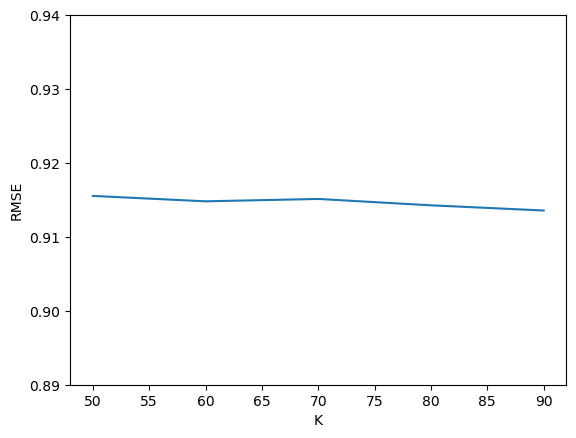

In [25]:
# 그래프 그리기
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.89, 0.94)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()